# EVSE Market Analysis
Note: This is run every *Wednesday*, and therefore will not work properly if run on any other day. Therefore, a switch was added so that it can be run using pre-defined datasets that were pulled from the NREL API previously (using this code). **Set the below switch (test_run_switch) to True if running this code without 2 weeks of past data.**

In [1]:
test_run_switch = False

In [2]:
import requests
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MaxNLocator
import seaborn as sns

sns.set(rc={"figure.figsize": (12, 9)}, style='ticks', context='talk')

In [3]:
data = requests.get('https://developer.nrel.gov/api/alt-fuel-stations/v1.json?access=public&status=E&fuel_type=ELEC&api_key=gICMTaBKdZnvi39aqPrUuye1jmFAaCEMngZYKVTN&format=JSON')
data = data.json()
# data = json.loads(data.text)
data = pd.DataFrame(data['fuel_stations'])

These functions do basic printouts or dataframe manipulations that I didn't want coded 2-3 times

In [4]:
def charge_level_summary(df):
    evse_counts = df.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
    evse_counts_melt = evse_counts.reset_index().melt(id_vars=['State'], var_name='Charge Level', value_name='Number of plugs')
    evse_plot= evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)[['Level 1', 'Level 2', 'DC Fast Charge']]
    tesla_evse = df[(df['EV Network'] == 'Tesla')&(df['DC Fast Charge'] > 0)]
    print('Station count (not including private stations):')
    print('{} DC Fast Chargers ({} plugs, {} plugs per station)'.format(df['DC Fast Charge'].count(), evse_plot.sum()['DC Fast Charge'].astype(int), (df['DC Fast Charge'].sum()/df['DC Fast Charge'].count()).round(2)))
    print('{} Level 2 Chargers ({} plugs, {} plugs per station))'.format(df['Level 2'].count(), evse_plot.sum()['Level 2'].astype(int), (df['Level 2'].sum()/df['Level 2'].count()).round(2)))
    print('{} Level 1 Chargers ({} plugs, {} plugs per station))'.format(df['Level 1'].count(), evse_plot.sum()['Level 1'].astype(int), (df['Level 1'].sum()/df['Level 1'].count()).round(2)))
    print('{} Tesla Superchargers ({} plugs, {} plugs per station))'.format(tesla_evse.shape[0], tesla_evse['DC Fast Charge'].sum().astype(int), (tesla_evse['DC Fast Charge'].sum()/tesla_evse['DC Fast Charge'].count()).round(2)))
    print('{} total plugs'.format(evse_plot.sum()['Level 1'].astype(int)+evse_plot.sum()['Level 2'].astype(int)+evse_plot.sum()['DC Fast Charge'].astype(int)))
    print('{} total chargers'.format(df.shape[0]))
def plugs_by_state(df, get='plugs'):
    if get=='stations':
        evse_counts = df.groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].count()
        return evse_counts
    else:
        evse_counts = df.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
        return evse_counts

Pull in the station count data from the previous 2 weeks for comparison (*_prev_2* and *_prev*), and grab/rename the relevant columns to create this weeks' dataset. Requires previous two weeks of EVSE market data (CSVs).

In [5]:
if test_run_switch:
    all_stations_prev_2 = pd.read_csv("alt_fuel_stations (December 26 2018).csv")
    all_stations_prev = pd.read_csv("alt_fuel_stations (January 02 2019).csv")
    all_stations = pd.read_csv("alt_fuel_stations (January 06 2019).csv")
else:
    all_stations_prev_2 = pd.read_csv("alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=14)).strftime("%B %d %Y")))
    all_stations_prev = pd.read_csv("alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=7)).strftime("%B %d %Y")))
    all_stations = data[['state','ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num','ev_network']].rename(columns={'state':'State',
                                        'ev_level1_evse_num':'Level 1', 'ev_level2_evse_num':'Level 2', 'ev_dc_fast_num':'DC Fast Charge',
                                        'ev_network':'EV Network'})

stations_list = [all_stations_prev_2, all_stations_prev, all_stations]

Save this week's dataset to csv.

In [6]:
if not test_run_switch:
    all_stations.to_csv('alt_fuel_stations ({}).csv'.format(dt.datetime.today().strftime("%B %d %Y")))

Print out some quick info for comparison (and dummy checking)

In [7]:
print('\t Last week')
charge_level_summary(all_stations_prev)
print('\n\tThis week')
charge_level_summary(all_stations)
print('\n{} additional stations since last time'.format(all_stations.shape[0] - all_stations_prev.shape[0]))

	 Last week
Station count (not including private stations):
2669 DC Fast Chargers (9862 plugs, 3.7 plugs per station)
19094 Level 2 Chargers (49477 plugs, 2.59 plugs per station))
875 Level 1 Chargers (1798 plugs, 2.05 plugs per station))
607 Tesla Superchargers (5561 plugs, 9.16 plugs per station))
61137 total plugs
21069 total chargers

	This week
Station count (not including private stations):
2694 DC Fast Chargers (10019 plugs, 3.72 plugs per station)
19186 Level 2 Chargers (49826 plugs, 2.6 plugs per station))
860 Level 1 Chargers (1775 plugs, 2.06 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61620 total plugs
21180 total chargers

111 additional stations since last time


Generate dataframes that show the change in number of plugs (*delta_plugs*) and stations (*delta_stations*) by state and charge level/speed. Save *delta_stations* to csv so that it can be edited (conditional formatting - highlighting) for use in the news update.  **attempt to automate the cell higlighting using xlsxwriter**

In [8]:
delta_plugs = ((plugs_by_state(all_stations,'plugs') - plugs_by_state(all_stations_prev,'plugs')).replace(0, np.nan).dropna(how='all', axis=0).fillna('-'))
delta_stations = ((plugs_by_state(all_stations,'stations') - plugs_by_state(all_stations_prev,'stations')).replace(0, np.nan).dropna(how='all', axis=0).fillna('-'))
delta_stations.to_csv('{}_deltstation.csv'.format(dt.date.today()))

In [9]:
delta_stations.to_excel('{}_deltstation.xlsx'.format(dt.date.today()))

Generate the station count dataframes that are used for plotting

In [10]:
evse_counts = all_stations.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
evse_counts_melt = evse_counts.reset_index().melt(id_vars=['State'], var_name='Charge Level', value_name='Number of plugs')
evse_counts_melt = evse_counts_melt[~evse_counts_melt['State'].isin(['Puerto Rico'])]
evse_plot= evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)[['Level 1', 'Level 2', 'DC Fast Charge']]

Generate the plug count dataframes (basically only used for the CA shares calculated in the next cell . . . )

In [11]:
plugs_by_state = evse_counts_melt.groupby('State')['Number of plugs'].sum()
state_shares = (evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1)/evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sum())*100
state_counts = evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)

Print out the CA shares that are directly copy/pasted into the caption for the EVSE figure in the AFV News Update doc.

In [12]:
print('CA Shares (plug counts):')
ca_shares_str = "{:.1f}% ({}), {:.1f}% ({}), and {:.1f}% ({})".format(state_shares.loc['CA',:]['Level 1'],int(state_counts.loc['CA',:]['Level 1']),
                                                    state_shares.loc['CA',:]['Level 2'],int(state_counts.loc['CA',:]['Level 2']),
                                                    state_shares.loc['CA',:]['DC Fast Charge'],int(state_counts.loc['CA',:]['DC Fast Charge']))
print(ca_shares_str)

try:
    ca_shares = pd.read_csv('all_CA_shares.csv', ';')[['date', 'text']].set_index('date', drop = True)
    ca_shares.loc[dt.date.today()] = ca_shares_str
except FileNotFoundError:
    ca_shares = pd.DataFrame({'date':[dt.date.today()], 'text': ca_shares_str})
    ca_shares.to_csv('all_CA_shares.csv', ';')

CA Shares (plug counts):
22.3% (395), 32.9% (16392), and 28.8% (2885)


C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


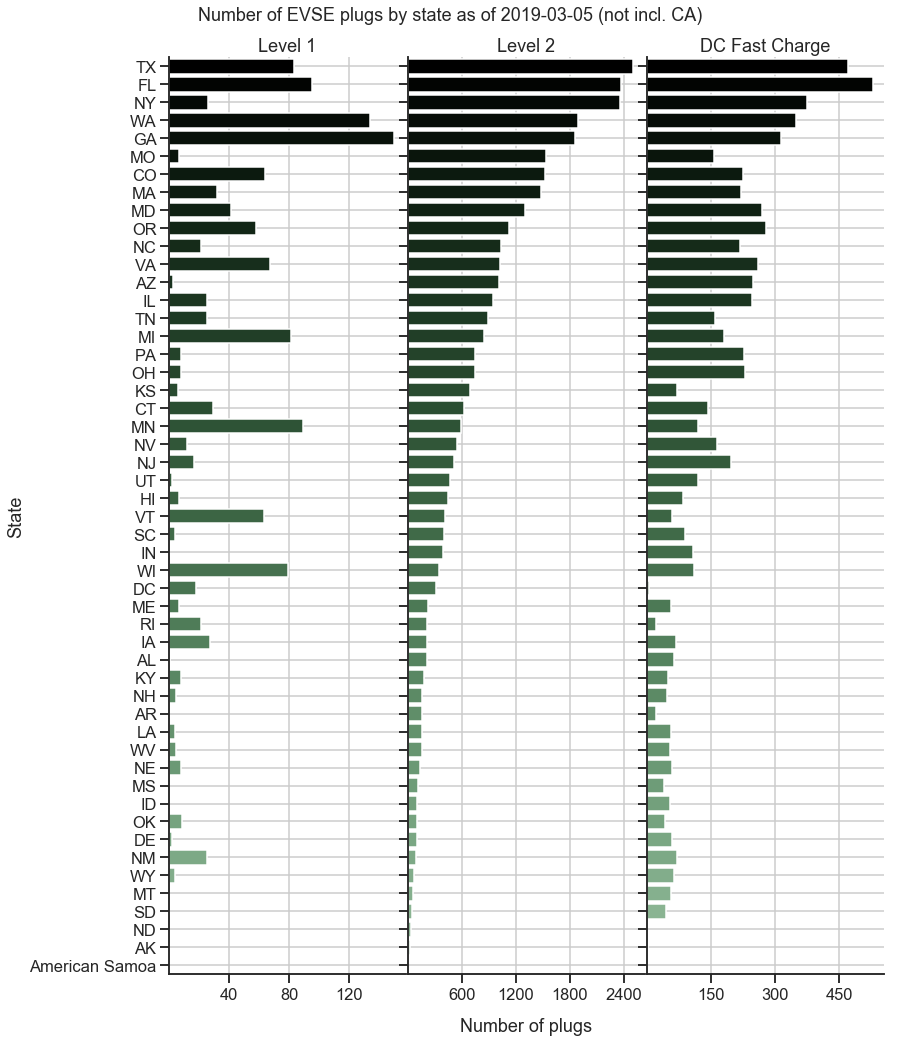

In [13]:
sns.set_style('ticks')
g = sns.factorplot(x='Number of plugs', y='State', col='Charge Level', data=evse_counts_melt[evse_counts_melt['State']!='CA'].sort_values('Number of plugs', ascending=False), 
               col_order=['Level 1', 'Level 2', 'DC Fast Charge'], kind='bar', aspect=0.3, size=14, 
                   palette=sns.cubehelix_palette(52, start=2, rot=0, dark=0, light=.7, reverse=True), sharex=False)
g.set_titles('{col_name}')
for axis in g.axes[0]:
    axis.xaxis.set_major_locator(MaxNLocator(prune='both'))
    axis.locator_params(axis='x', nbins=5)
    axis.grid(axis='both')
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('Number of plugs', labelpad=15)
g.axes[0][2].set_xlabel('')
plt.subplots_adjust(wspace=0.01)
plt.suptitle('Number of EVSE plugs by state as of {} (not incl. CA)'.format(dt.date.today()), fontsize=18, y=1.02)
plt.savefig(f'EVSE_bar_chart_{str(dt.date.today())}') # Must match news scraper format
plt.show()

### Notes:
* For the **requests** package: https://stackoverflow.com/questions/25067580/passing-web-data-into-beautiful-soup-empty-list
* BeautifulSoup documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* NREL API: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/
* strftime reference: http://strftime.org/